# Setup Environment

In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv

from huggingface_hub import login

import polars as pl
import torch

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
)
from datasets import Dataset, DatasetDict, load_dataset


torch.cuda.empty_cache()

load_dotenv()


HF_TOKEN = os.getenv("HF_TOKEN")

login(token=HF_TOKEN, add_to_git_credential=True)

/home/octoopt/workspace/projects/learn-from-basics/the-notes/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
ROOT_DIR = Path(".").resolve()
DATA_DIR = ROOT_DIR / "dataset" / "storage" / "multi_language"

print(f"Using device: {DEVICE}")

Using device: cuda


# Setup Experiment

## EDA

In [ ]:
dataset_id = "minhleduc/multilang-classify-dataset-01"
dataset = load_dataset(dataset_id)
dataset

Generating train split: 100%|██████████| 32126/32126 [00:00<00:00, 346525.80 examples/s]


DatasetDict({
    train: Dataset({
        features: ['Text', 'Language'],
        num_rows: 32126
    })
})

In [9]:
dataset_pl = dataset["train"].to_polars()
dataset_pl

Text,Language
str,str
"""Graças à colaboração de volunt…","""Portugeese"""
"""à linitiative des intercommuna…","""French"""
"""هل يمكنك الانتظار لحظة من فضلك…","""Arabic"""
"""يجب ألا يقدم بحثًا أصليًا.""","""Arabic"""
"""временные члены вызываются на …","""Russian"""
…,…
"""أنتجت شبكة pbs الأمريكية عام …","""Arabic"""
"""bitirmeme izin ver.""","""Turkish"""
"""El proyecto Wikipedia se inici…","""Spanish"""


Text,Language
str,str
"""Graças à colaboração de volunt…","""Portugeese"""
"""à linitiative des intercommuna…","""French"""
"""هل يمكنك الانتظار لحظة من فضلك…","""Arabic"""
"""يجب ألا يقدم بحثًا أصليًا.""","""Arabic"""
"""временные члены вызываются на …","""Russian"""


In [24]:
# To get the count of each unique value in the 'Language' column
languages = dataset_pl["Language"].unique()
print(languages)
for language in languages:
    print(language)

shape: (30,)
Series: 'Language' [str]
[
	"English"
	"Japanese"
	"Hindi"
	"Latin"
	"Thai"
	…
	"Portugeese"
	"Persian"
	"Chinese"
	"Pushto"
	"Danish"
]
English
Japanese
Hindi
Latin
Thai
Spanish
German
Tamil
Romanian
Arabic
Swedish
Greek
French
Dutch
Kannada
Estonian
Malayalam
Korean
Portugese
Urdu
Sweedish
Russian
Turkish
Italian
Indonesian
Portugeese
Persian
Chinese
Pushto
Danish


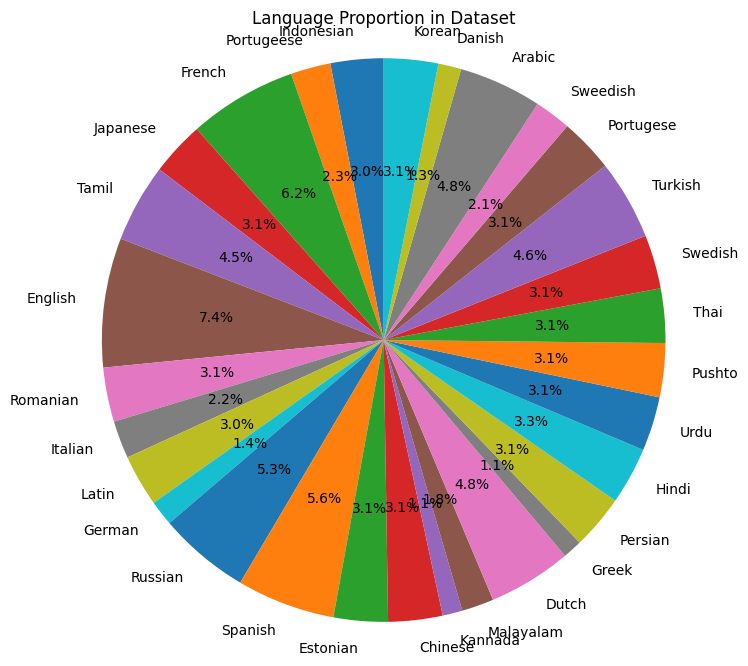

In [35]:
language_counts = dataset_pl["Language"].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(
    language_counts["count"],
    labels=language_counts["Language"],
    autopct="%1.1f%%",
    startangle=90,
)
plt.title("Language Proportion in Dataset")
plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the plot
plt.show()

In [ ]:
# Shuffle the dataset
dataset_pl = dataset_pl.sample(fraction=1, shuffle=True, seed=42)

# Calculate split sizes
n = len(dataset_pl)
train_size = 0.8
val_test_size = 0.1  # 10% for validation, 10% for test

train_n = int(n * train_size)
val_n = int(n * val_test_size)

# Split the data
train_df = dataset_pl.head(train_n)
remaining = dataset_pl.tail(n - train_n)

val_df = remaining.head(val_n)
test_df = remaining.tail(len(remaining) - val_n)

# Verify the splits
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

In [37]:
add_pl = load_dataset("papluca/language-identification")
add_pl

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 70000
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
})

In [39]:
train_add = add_pl["train"].to_polars()
val_add = add_pl["validation"].to_polars()
test_add = add_pl["test"].to_polars()

In [43]:
# Concatenate the DataFrames vertically (stack on top of each other)
combined_df = pl.concat([train_add, val_add, test_add], how="vertical")

# Verify the concatenation
print(f"Total rows after concatenation: {len(combined_df)}")
print(f"Train rows: {len(train_add)}")
print(f"Validation rows: {len(val_add)}")
print(f"Test rows: {len(test_add)}")

Total rows after concatenation: 90000
Train rows: 70000
Validation rows: 10000
Test rows: 10000


In [48]:
add_langs = combined_df["labels"].unique()

print(add_langs)
for lang in add_langs:
    print(lang)

shape: (20,)
Series: 'labels' [str]
[
	"ar"
	"de"
	"pt"
	"en"
	"nl"
	…
	"tr"
	"vi"
	"ja"
	"bg"
	"zh"
]
ar
de
pt
en
nl
th
ru
fr
hi
pl
it
el
ur
sw
es
tr
vi
ja
bg
zh


In [50]:
# Create a mapping dictionary for language codes to full names
language_mapping = {
    "ar": "Arabic",
    "bg": "Bulgarian",
    "de": "German",
    "el": "Modern Greek",
    "en": "English",
    "es": "Spanish",
    "fr": "French",
    "hi": "Hindi",
    "it": "Italian",
    "ja": "Japanese",
    "nl": "Dutch",
    "pl": "Polish",
    "pt": "Portuguese",
    "ru": "Russian",
    "sw": "Swahili",
    "th": "Thai",
    "tr": "Turkish",
    "ur": "Urdu",
    "vi": "Vietnamese",
    "zh": "Chinese",
}

# Assuming your language column is named 'Language'
# Replace the language codes with full names
combined_df = combined_df.with_columns(pl.col("labels").replace(language_mapping))

In [52]:
combined_df = combined_df.rename({"labels": "Language", "text": "Text"})

In [54]:
combined_df

Language,Text
str,str
"""Portuguese""","""os chefes de defesa da estónia…"
"""Bulgarian""","""размерът на хоризонталната мре…"
"""Chinese""","""很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以…"
"""Thai""","""สำหรับ ของเก่า ที่ จริงจัง ลอง…"
"""Russian""","""Он увеличил давление ."""
…,…
"""Chinese""","""史料很充分，对岸的很多观点与大陆迥异啊。"""
"""Turkish""","""Örneğin, teşhis Yunanca bir ke…"
"""Vietnamese""","""Nếu lite/light chỉ đơn giản là…"


In [55]:
dataset_pl

Text,Language
str,str
"""Graças à colaboração de volunt…","""Portugeese"""
"""à linitiative des intercommuna…","""French"""
"""هل يمكنك الانتظار لحظة من فضلك…","""Arabic"""
"""يجب ألا يقدم بحثًا أصليًا.""","""Arabic"""
"""временные члены вызываются на …","""Russian"""
…,…
"""أنتجت شبكة pbs الأمريكية عام …","""Arabic"""
"""bitirmeme izin ver.""","""Turkish"""
"""El proyecto Wikipedia se inici…","""Spanish"""


In [56]:
# Reorder the columns in dataset_pl to match the order in combined_df
dataset_pl_reordered = dataset_pl.select(["Language", "Text"])

# Now you can concatenate them
final_df = pl.concat([combined_df, dataset_pl_reordered])

# Verify the result
print(final_df.head())
print(f"Shape of final DataFrame: {final_df.shape}")

shape: (5, 2)
┌────────────┬─────────────────────────────────┐
│ Language   ┆ Text                            │
│ ---        ┆ ---                             │
│ str        ┆ str                             │
╞════════════╪═════════════════════════════════╡
│ Portuguese ┆ os chefes de defesa da estónia… │
│ Bulgarian  ┆ размерът на хоризонталната мре… │
│ Chinese    ┆ 很好，以前从不去评价，不知道浪  │
│            ┆ 费了多少积分，现在知道积分可以… │
│ Thai       ┆ สำหรับ ของเก่า ที่ จริงจัง ลอง…       │
│ Russian    ┆ Он увеличил давление .          │
└────────────┴─────────────────────────────────┘
Shape of final DataFrame: (122126, 2)


In [57]:
# Clean the 'Text' column
final_df_cleaned = final_df.with_columns(
    pl.col("Text")
    .str.to_lowercase()
    .str.replace_all(r"http\S+|www.\S+", "")  # Remove URLs
    .str.replace_all(r"<.*?>", "")  # Remove HTML tags
    .str.replace_all(r"[^\p{L}\s]", "")  # Remove punctuation and special characters
    .str.replace_all(r"\d+", "")  # Remove numbers
    .str.replace_all(r"\s+", " ")  # Replace multiple spaces with a single space
    .str.strip_chars()  # Remove leading/trailing whitespace
)

# Display the cleaned DataFrame
print(final_df_cleaned.head())

shape: (5, 2)
┌────────────┬─────────────────────────────────┐
│ Language   ┆ Text                            │
│ ---        ┆ ---                             │
│ str        ┆ str                             │
╞════════════╪═════════════════════════════════╡
│ Portuguese ┆ os chefes de defesa da estónia… │
│ Bulgarian  ┆ размерът на хоризонталната мре… │
│ Chinese    ┆ 很好以前从不去评价不知道浪费了  │
│            ┆ 多少积分现在知道积分可以换钱就… │
│ Thai       ┆ สำหรบ ของเกา ท จรงจง ลอง honey… │
│ Russian    ┆ он увеличил давление            │
└────────────┴─────────────────────────────────┘


In [58]:
# Remove duplicate rows based on the 'Text' column
final_df_unique = final_df_cleaned.unique(subset=["Text"], keep="first")

# Verify the result by checking the shape
print(f"Shape before removing duplicates: {final_df_cleaned.shape}")
print(f"Shape after removing duplicates: {final_df_unique.shape}")

# Display the DataFrame without duplicates
print(final_df_unique.head())

Shape before removing duplicates: (122126, 2)
Shape after removing duplicates: (119083, 2)
shape: (5, 2)
┌──────────┬─────────────────────────────────┐
│ Language ┆ Text                            │
│ ---      ┆ ---                             │
│ str      ┆ str                             │
╞══════════╪═════════════════════════════════╡
│ Urdu     ┆ قانون سازی کے حوالے سے ء کے او… │
│ Swahili  ┆ karibu na thamani kamili yeah   │
│ Swahili  ┆ ndani ya milango wengi wa fara… │
│ Italian  ┆ putin lancia la scheda elettor… │
│ Polish   ┆ opóźnienia sztormowe rozpoczęc… │
└──────────┴─────────────────────────────────┘


In [60]:
from datasets import Dataset, DatasetDict, ClassLabel

# Assuming 'final_df_unique' is your cleaned Polars DataFrame
hf_dataset = Dataset.from_polars(final_df_unique)

# Step 1: Convert the 'Language' column to a ClassLabel type
# This creates an integer mapping for your string labels
hf_dataset = hf_dataset.class_encode_column("Language")

# Now you can stratify the split
# Step 2: Split into training (70%) and a temporary set (30%)
train_test_split = hf_dataset.train_test_split(
    test_size=0.3, seed=42, stratify_by_column="Language"
)

train_dataset = train_test_split["train"]
temp_dataset = train_test_split["test"]

# Step 3: Split the temporary set into validation (15%) and test (15%)
val_test_split = temp_dataset.train_test_split(
    test_size=0.5, seed=42, stratify_by_column="Language"
)

val_dataset = val_test_split["train"]
test_dataset = val_test_split["test"]

# Step 4: Combine them into a single DatasetDict
final_dataset_splits = DatasetDict(
    {"train": train_dataset, "validation": val_dataset, "test": test_dataset}
)

# Verify the splits and the new feature type
print(final_dataset_splits)
print(f"\nTraining examples: {len(final_dataset_splits['train'])}")
print(f"Validation examples: {len(final_dataset_splits['validation'])}")
print(f"Test examples: {len(final_dataset_splits['test'])}")

Casting to class labels: 100%|██████████| 119083/119083 [00:00<00:00, 497157.03 examples/s]


DatasetDict({
    train: Dataset({
        features: ['Language', 'Text'],
        num_rows: 83358
    })
    validation: Dataset({
        features: ['Language', 'Text'],
        num_rows: 17862
    })
    test: Dataset({
        features: ['Language', 'Text'],
        num_rows: 17863
    })
})

Training examples: 83358
Validation examples: 17862
Test examples: 17863


In [61]:
final_dataset_splits.push_to_hub(
    "minhleduc/multilang-classify-dataset-02",
    commit_message="Update dataset minhleduc/multilang-classify-dataset-01",
)

Uploading the dataset shards: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/minhleduc/multilang-classify-dataset-02/commit/fb8334e1e447a33ea938e503468f142eb34c68a2', commit_message='Update dataset minhleduc/multilang-classify-dataset-01', commit_description='', oid='fb8334e1e447a33ea938e503468f142eb34c68a2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/minhleduc/multilang-classify-dataset-02', endpoint='https://huggingface.co', repo_type='dataset', repo_id='minhleduc/multilang-classify-dataset-02'), pr_revision=None, pr_num=None)

# Experiment